# Experiment : Frozen Noise Classification

In this experiment, the simulator will be used to classify two random frozen noise patterns

### Imports

In [1]:
# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Jax Imports
from jax import random as rand
from jax import numpy as jnp

from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    dynapsim_net_from_config,
    DynapseSamna,
)

from utils import FrozenNoiseDataset

# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Step 1 : Input 

In [2]:
train_data = FrozenNoiseDataset(2)
test_data = FrozenNoiseDataset(10, seed=2023)

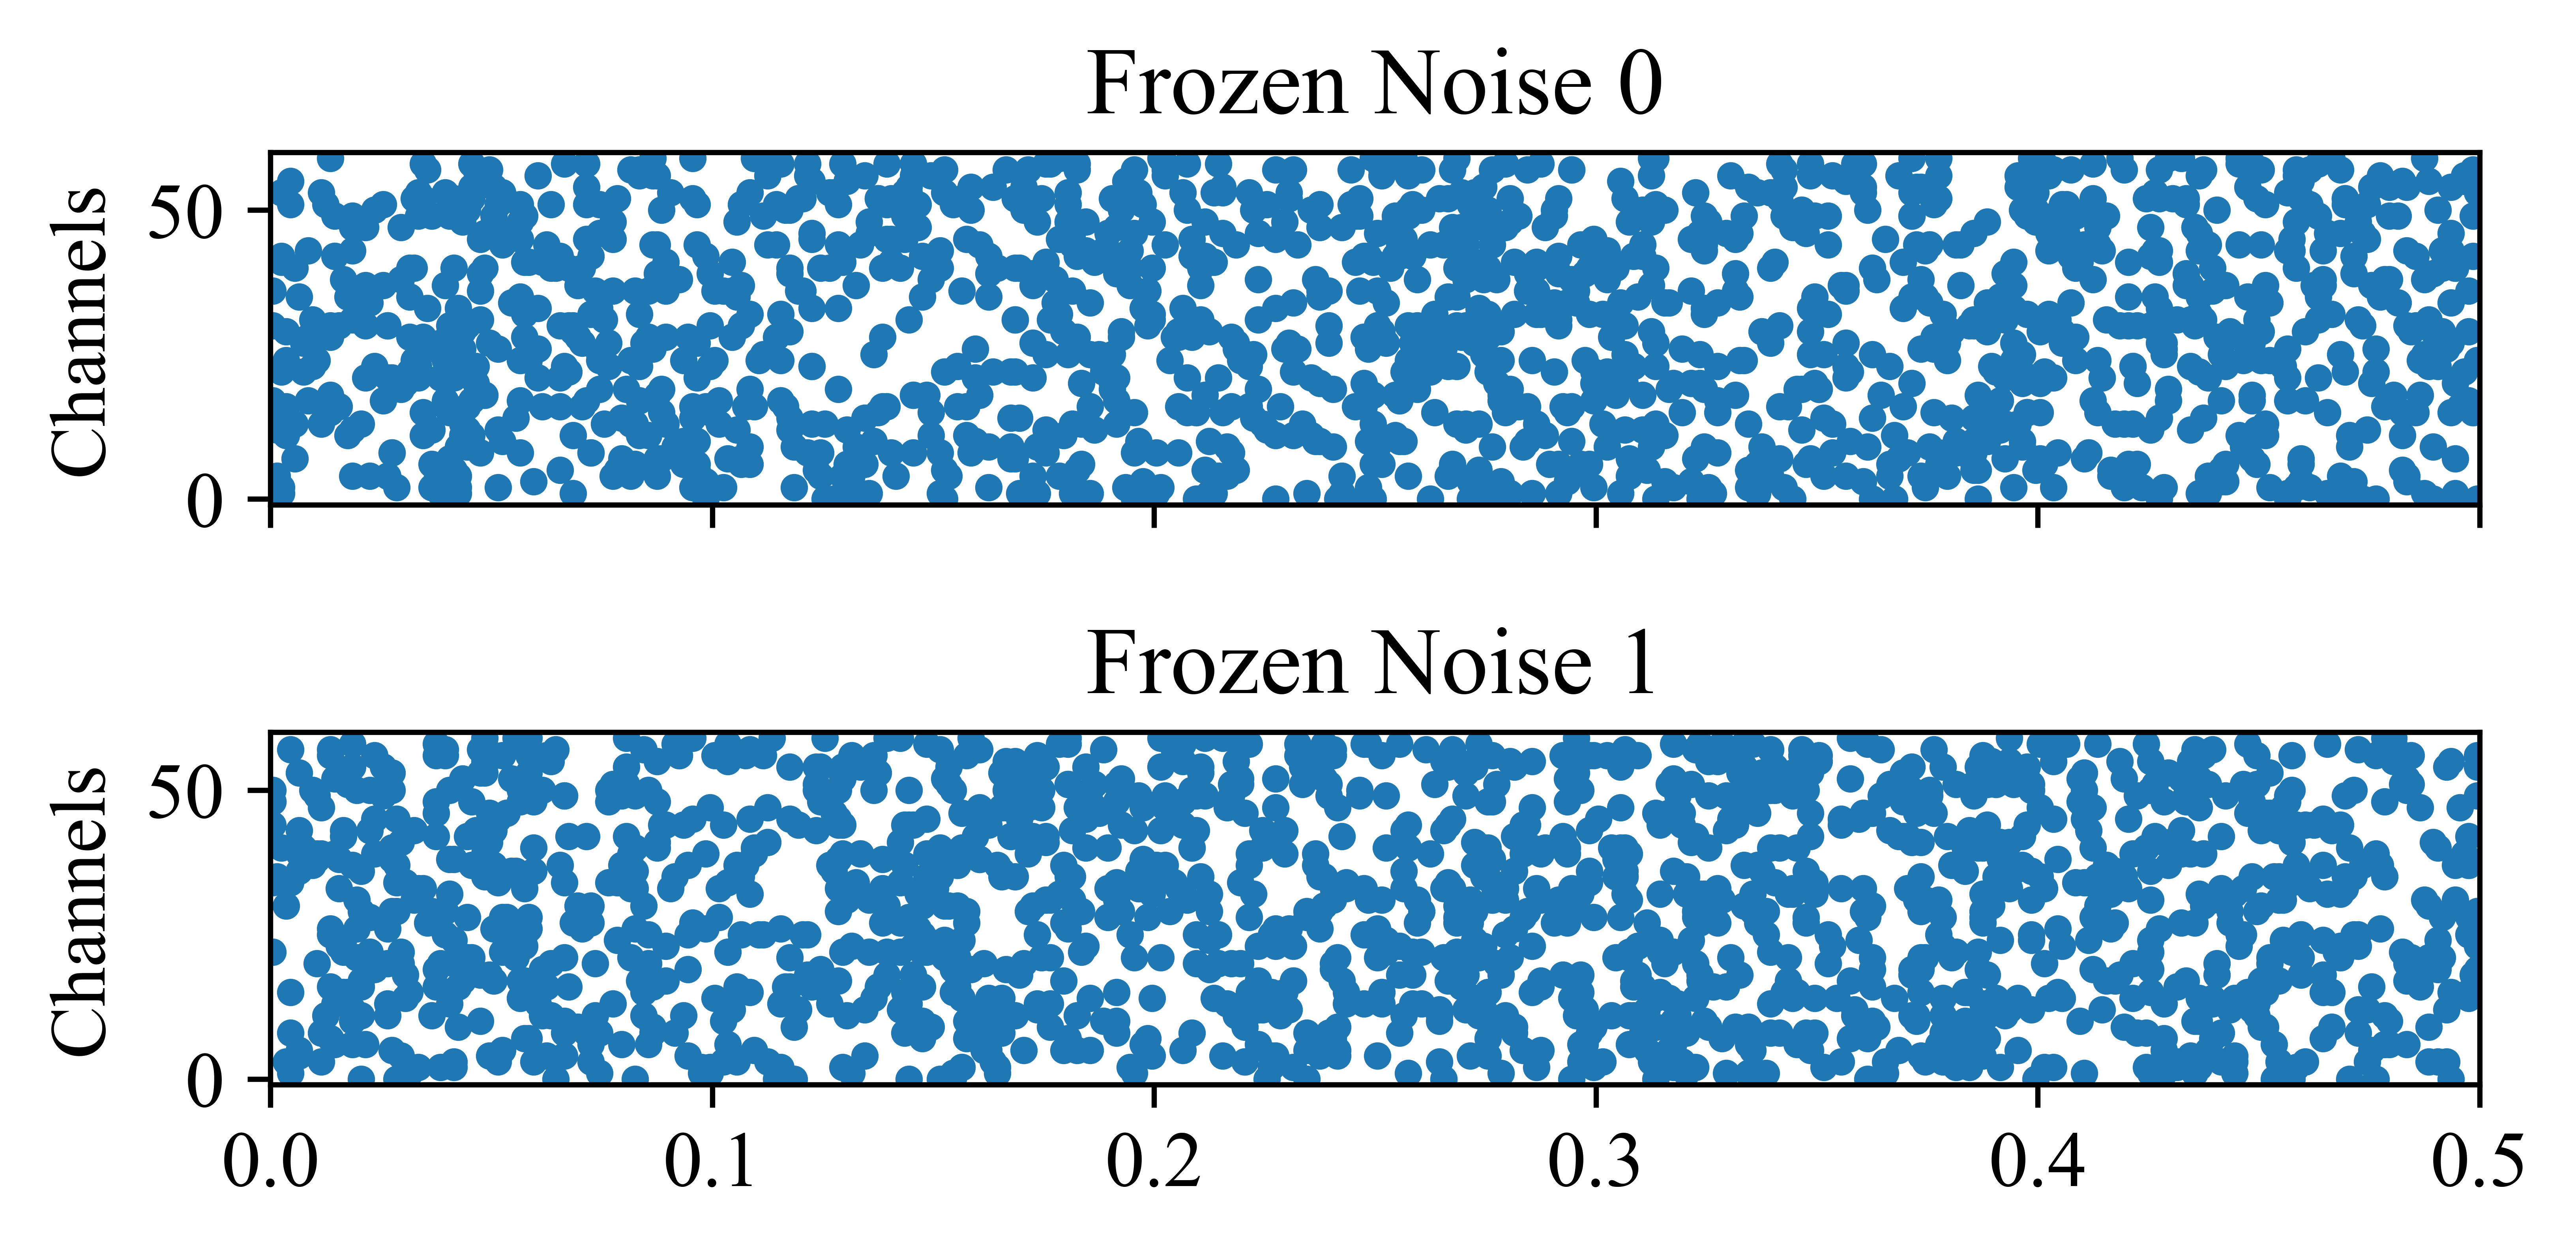

In [3]:
train_data.plot_samples(adjust_size=False)

## Step 2 : Network Configuration

Using the simulation configuration object, create a dynapse simulator

In [4]:
with open("data/w_in_optimized.npy", "rb") as f:
    w_in_optimized = np.load(f)

with open("data/w_rec_optimized.npy", "rb") as f:
    w_rec_optimized = np.load(f)

In [5]:
Nin = train_data.n_in
Nrec = train_data.n_out

In [6]:
# --- Input Layer --- #
linear_in = LinearJax(shape=(Nin, Nrec), has_bias=False, weight=w_in_optimized)
linear_in


LinearJax  with shape (60, 2)

In [7]:
# --- DynapSim Layer --- #
dynapsim = DynapSim((Nrec, Nrec), has_rec=True, w_rec = w_rec_optimized, percent_mismatch=0.05)
dynapsim

DynapSim  with shape (2, 2)

In [8]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

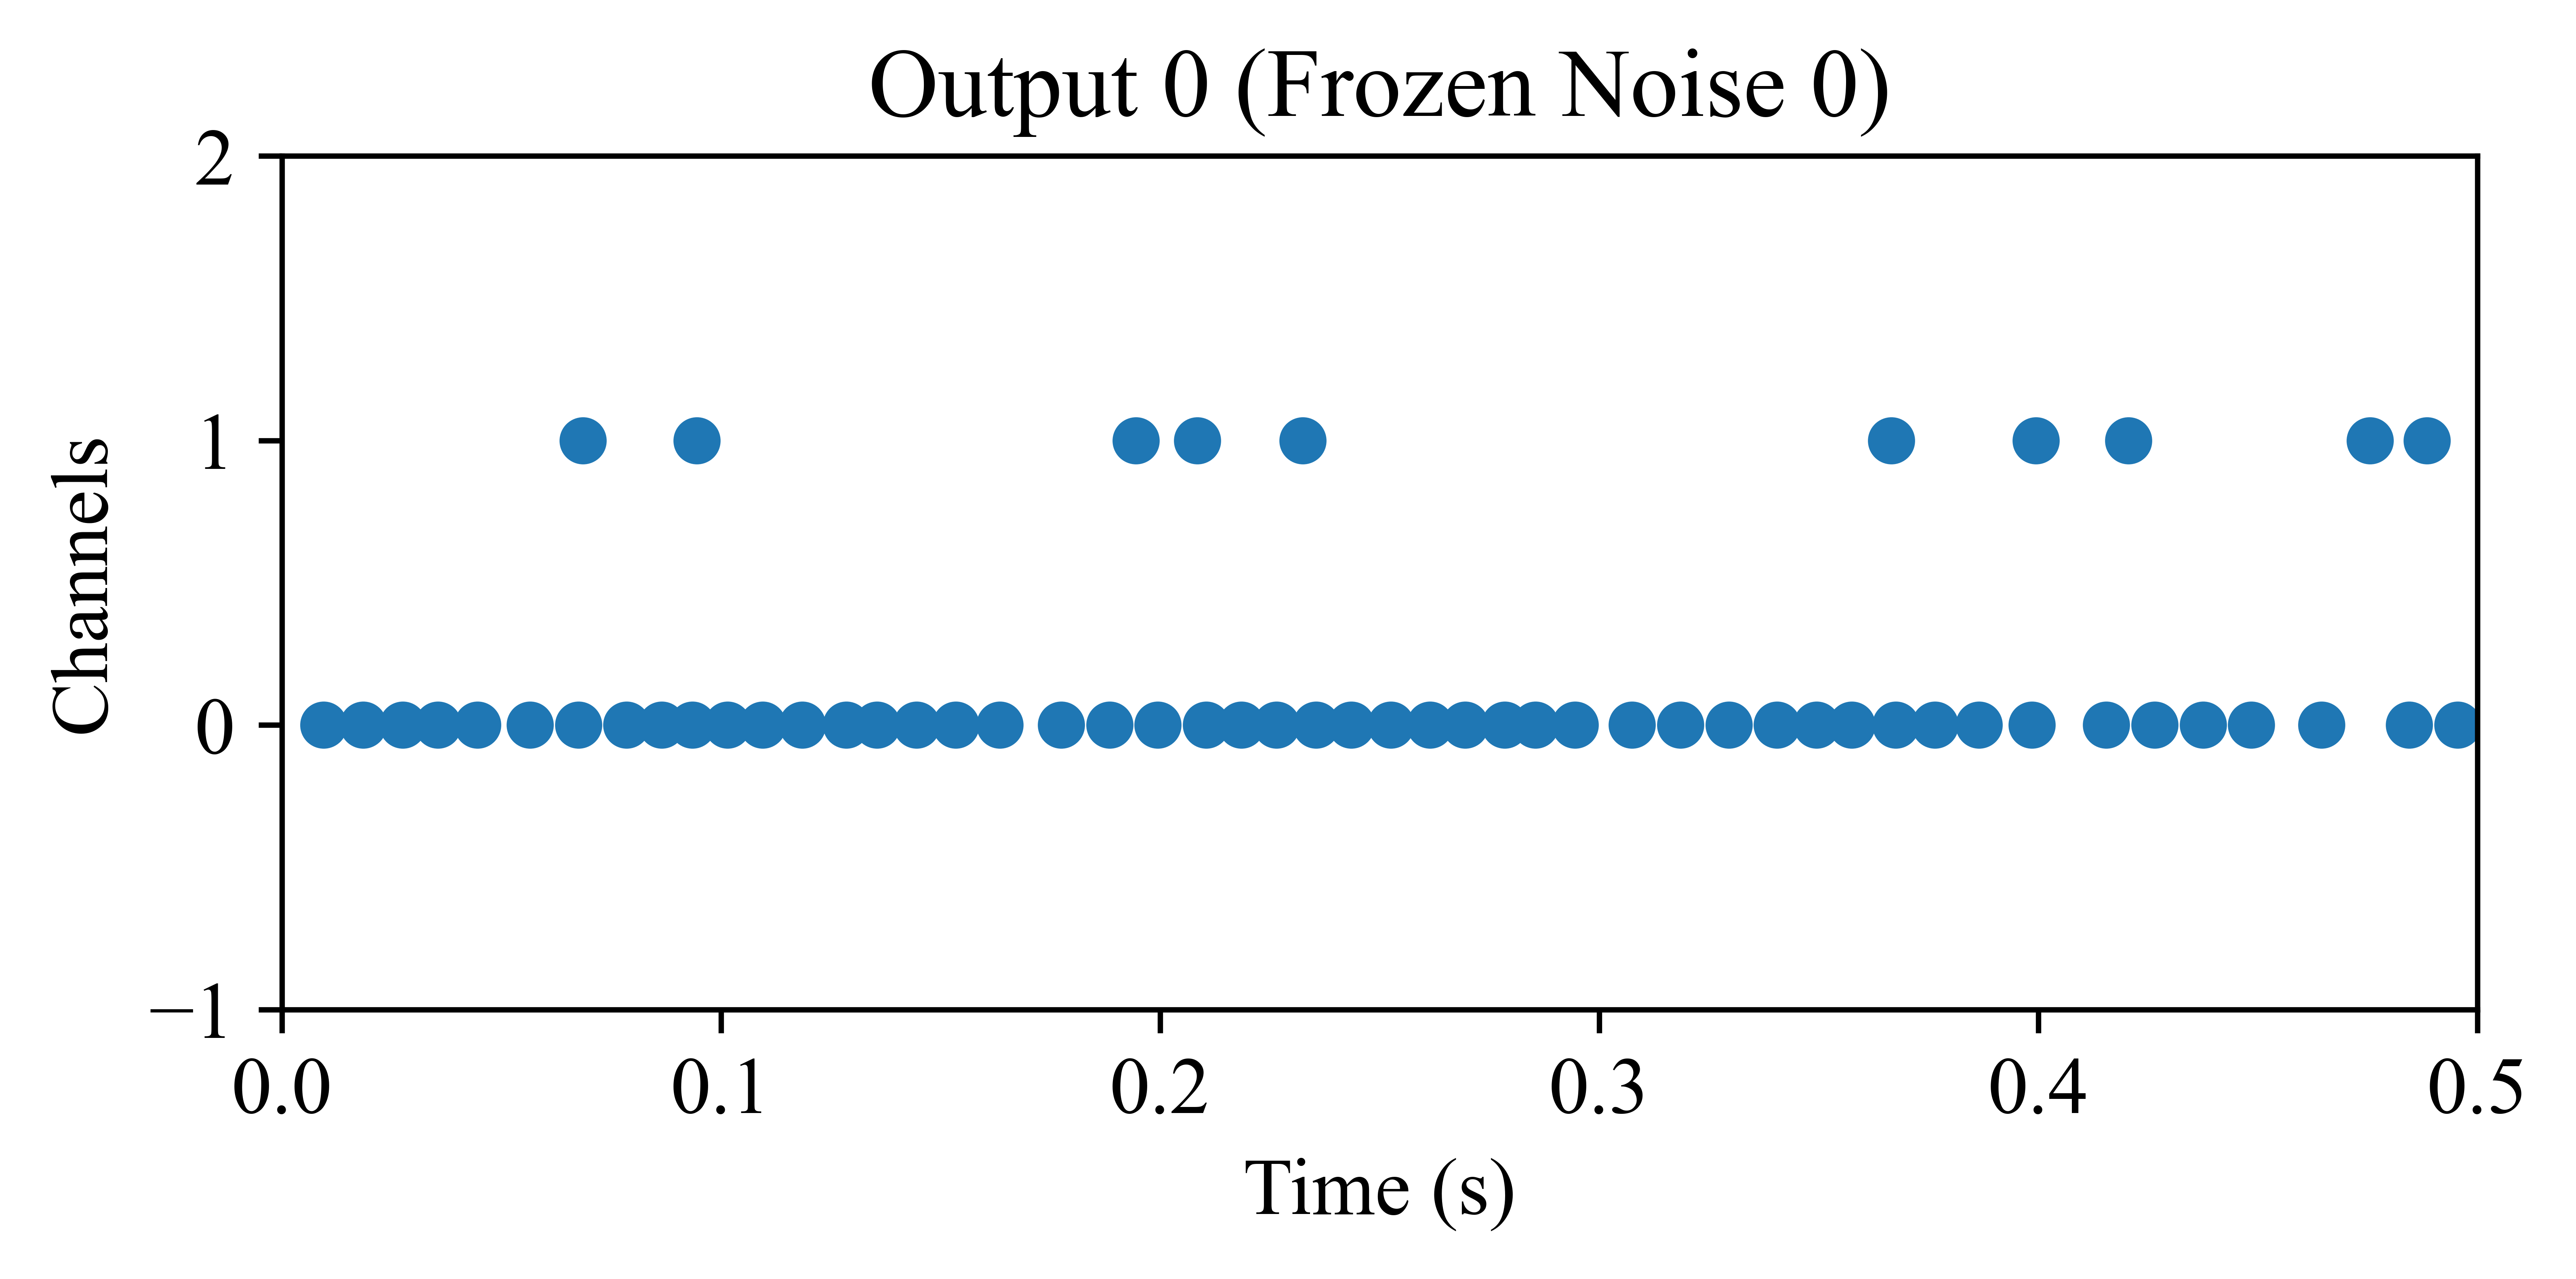

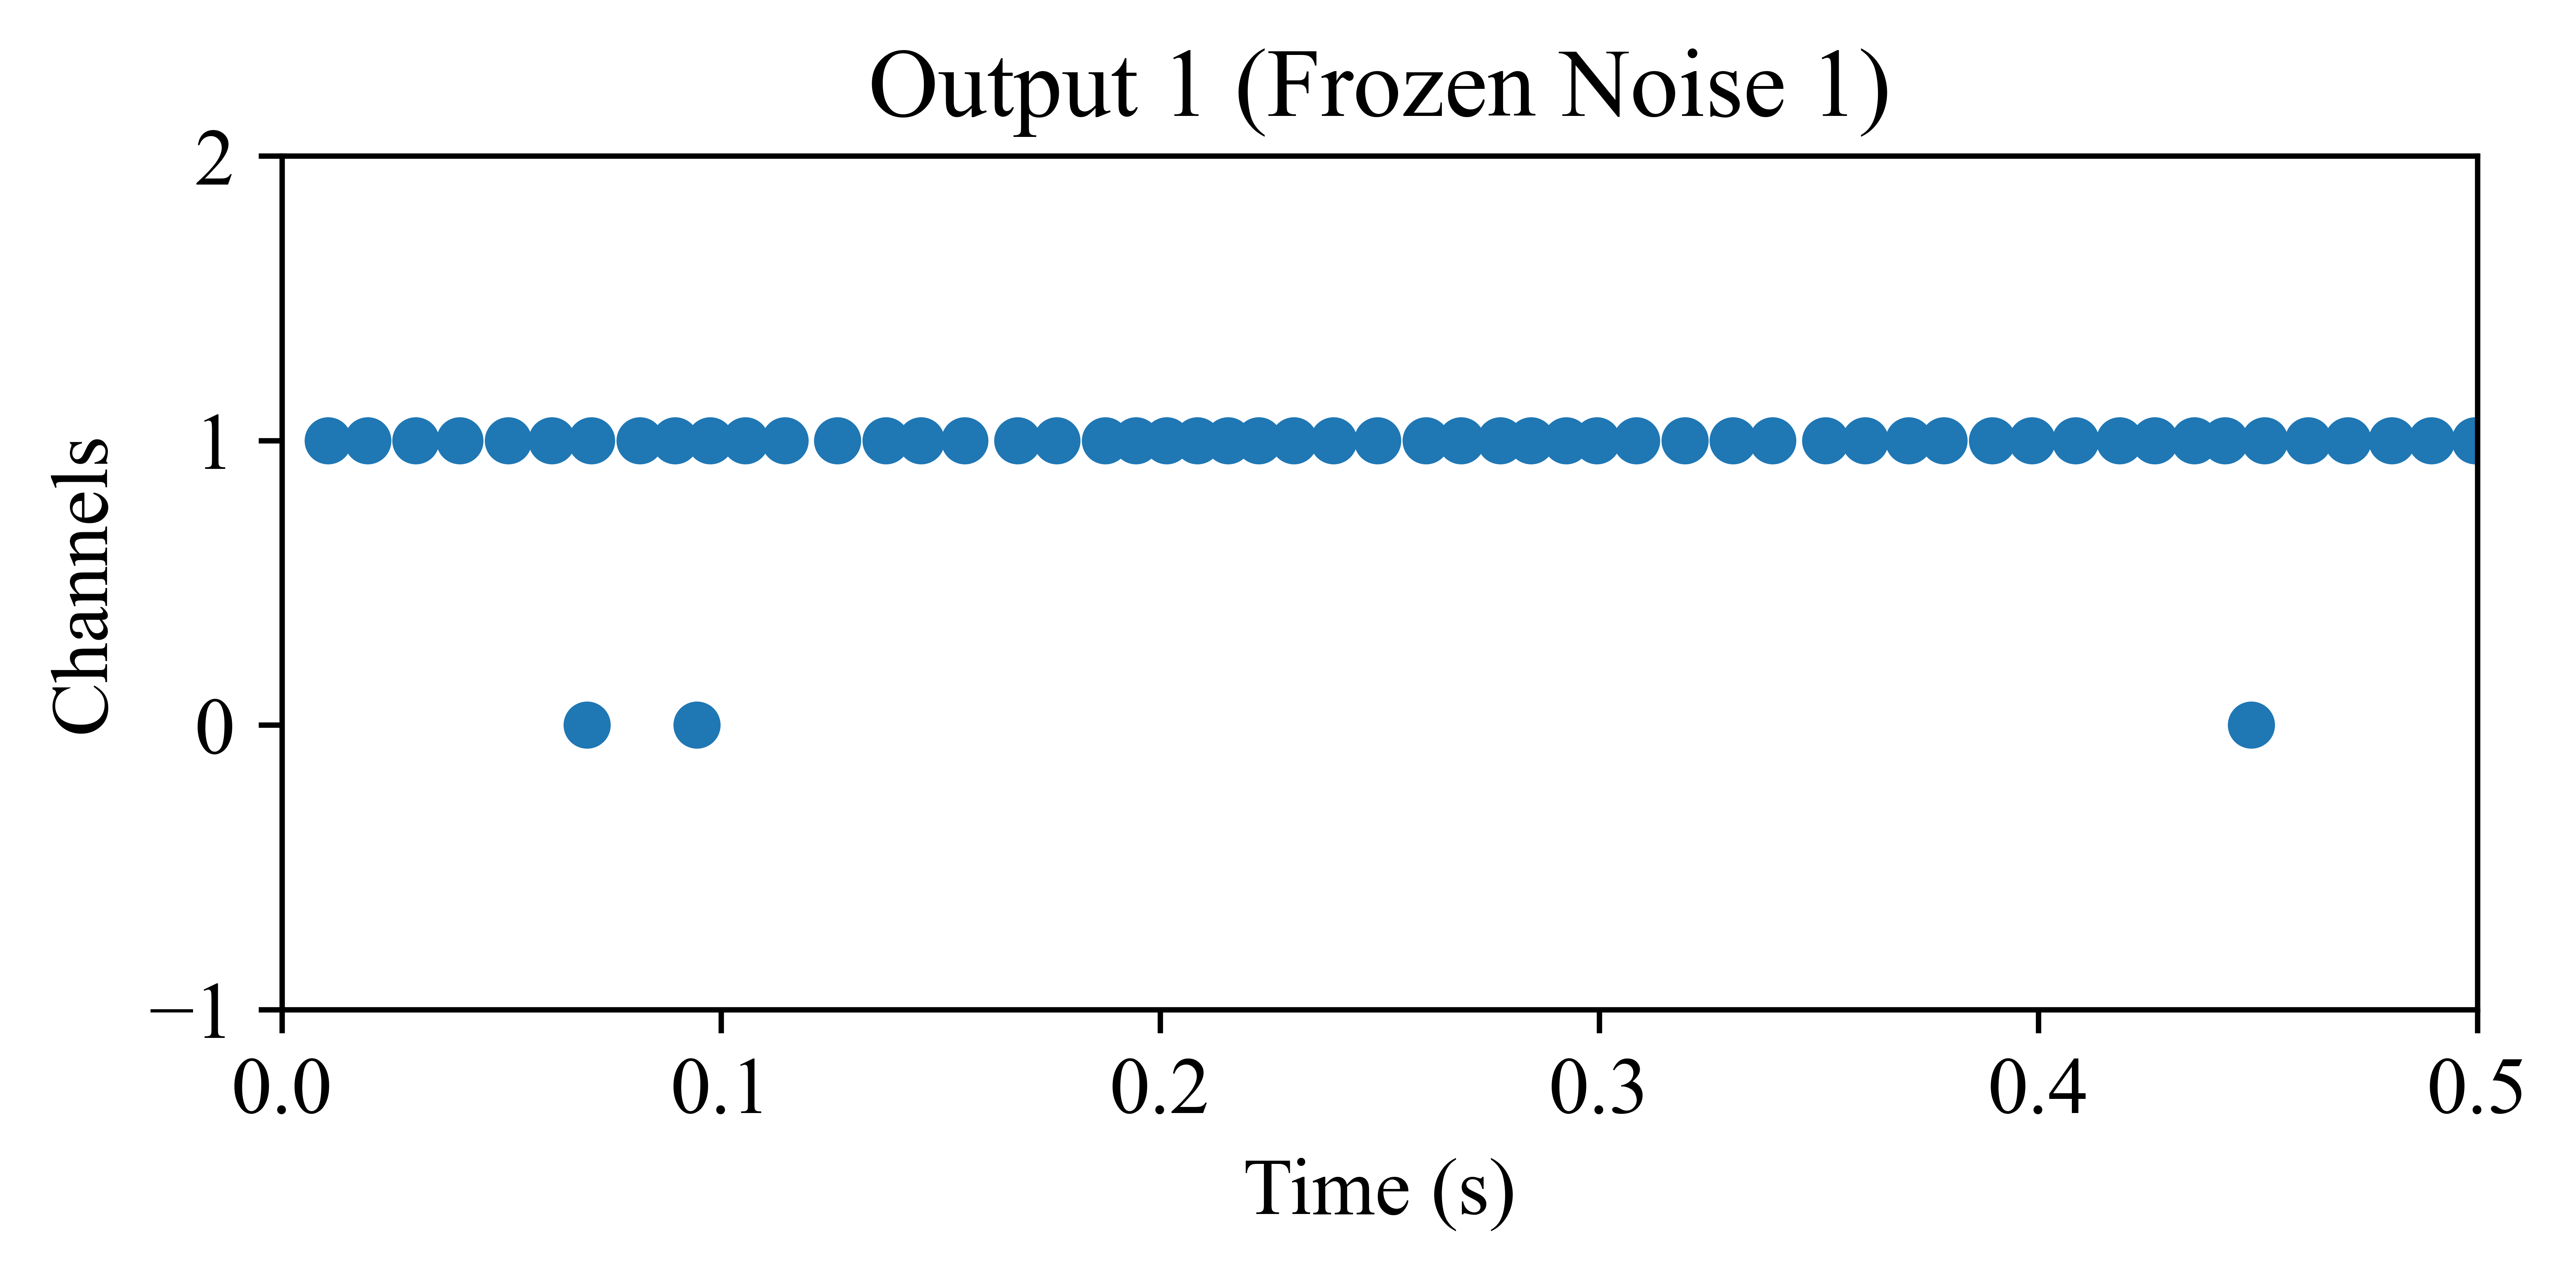

In [9]:
rec_init = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model.reset_state()
    out, _, rec = model(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

## Step 3 : Load the optimized weights

In [10]:
model.as_graph()

GraphHolder "JaxSequential__11374646544" with 60 input nodes -> 2 output nodes

In [11]:
spec = mapper(model.as_graph())
spec["Iscale"] *= 50

In [12]:
spec.update(autoencoder_quantization(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11374646544" with 60 input nodes -> 2 output nodes,
 'weights_in': [array([[ 2,  0],
         [ 6, 15],
         [10, 15],
         [12,  0],
         [14,  6],
         [ 7,  0],
         [ 0, 10],
         [ 9, 11],
         [12,  0],
         [ 1,  0],
         [ 0,  0],
         [ 5,  0],
         [ 7, 11],
         [ 1, 12],
         [ 9,  7],
         [12,  0],
         [ 7,  6],
         [ 0,  0],
         [ 5,  2],
         [11,  0],
         [ 0,  0],
         [10,  2],
         [15,  6],
         [ 0, 11],
         [13,  7],
         [ 9, 10],
         [ 1,  7],
         [ 9,  0],
         [12,  0],
         [ 0,  9],
         [ 3,  0],
         [ 0,  0],
         [ 0, 15],
         [12, 15],
         [ 0,  0],
         [11,  0],
         [ 8,  8],
         [15,  0],
         [15,  0],
         [15,  3],
         [13,  0],
         [ 8, 13],
         [ 3,  6],
         [ 1,  0],
         [ 0,  0],
         [ 0,  9],
         [ 9,  

In [13]:
config, input_channel_map = config_from_specification(**spec)

In [14]:
model_quantized = dynapsim_net_from_config(config, input_channel_map)

In [15]:
model_quantized[0].weight

array([[ -49.38702101,    0.        ],
       [  98.77404202, -197.54808404],
       [ -98.77404202, -197.54808404],
       [ -98.77404202,    0.        ],
       [ 148.16106303,  -98.77404202],
       [-148.16106303,    0.        ],
       [   0.        ,  -98.77404202],
       [ -98.77404202, -148.16106303],
       [ -98.77404202,    0.        ],
       [ -49.38702101,    0.        ],
       [   0.        ,    0.        ],
       [ -98.77404202,    0.        ],
       [-148.16106303, -148.16106303],
       [  49.38702101,  -98.77404202],
       [ -98.77404202,  148.16106303],
       [ -98.77404202,    0.        ],
       [-148.16106303,  -98.77404202],
       [   0.        ,    0.        ],
       [ -98.77404202,  -49.38702101],
       [ 148.16106303,    0.        ],
       [   0.        ,    0.        ],
       [ -98.77404202,  -49.38702101],
       [-197.54808404,  -98.77404202],
       [   0.        , -148.16106303],
       [-148.16106303, -148.16106303],
       [ -98.77404202,  -

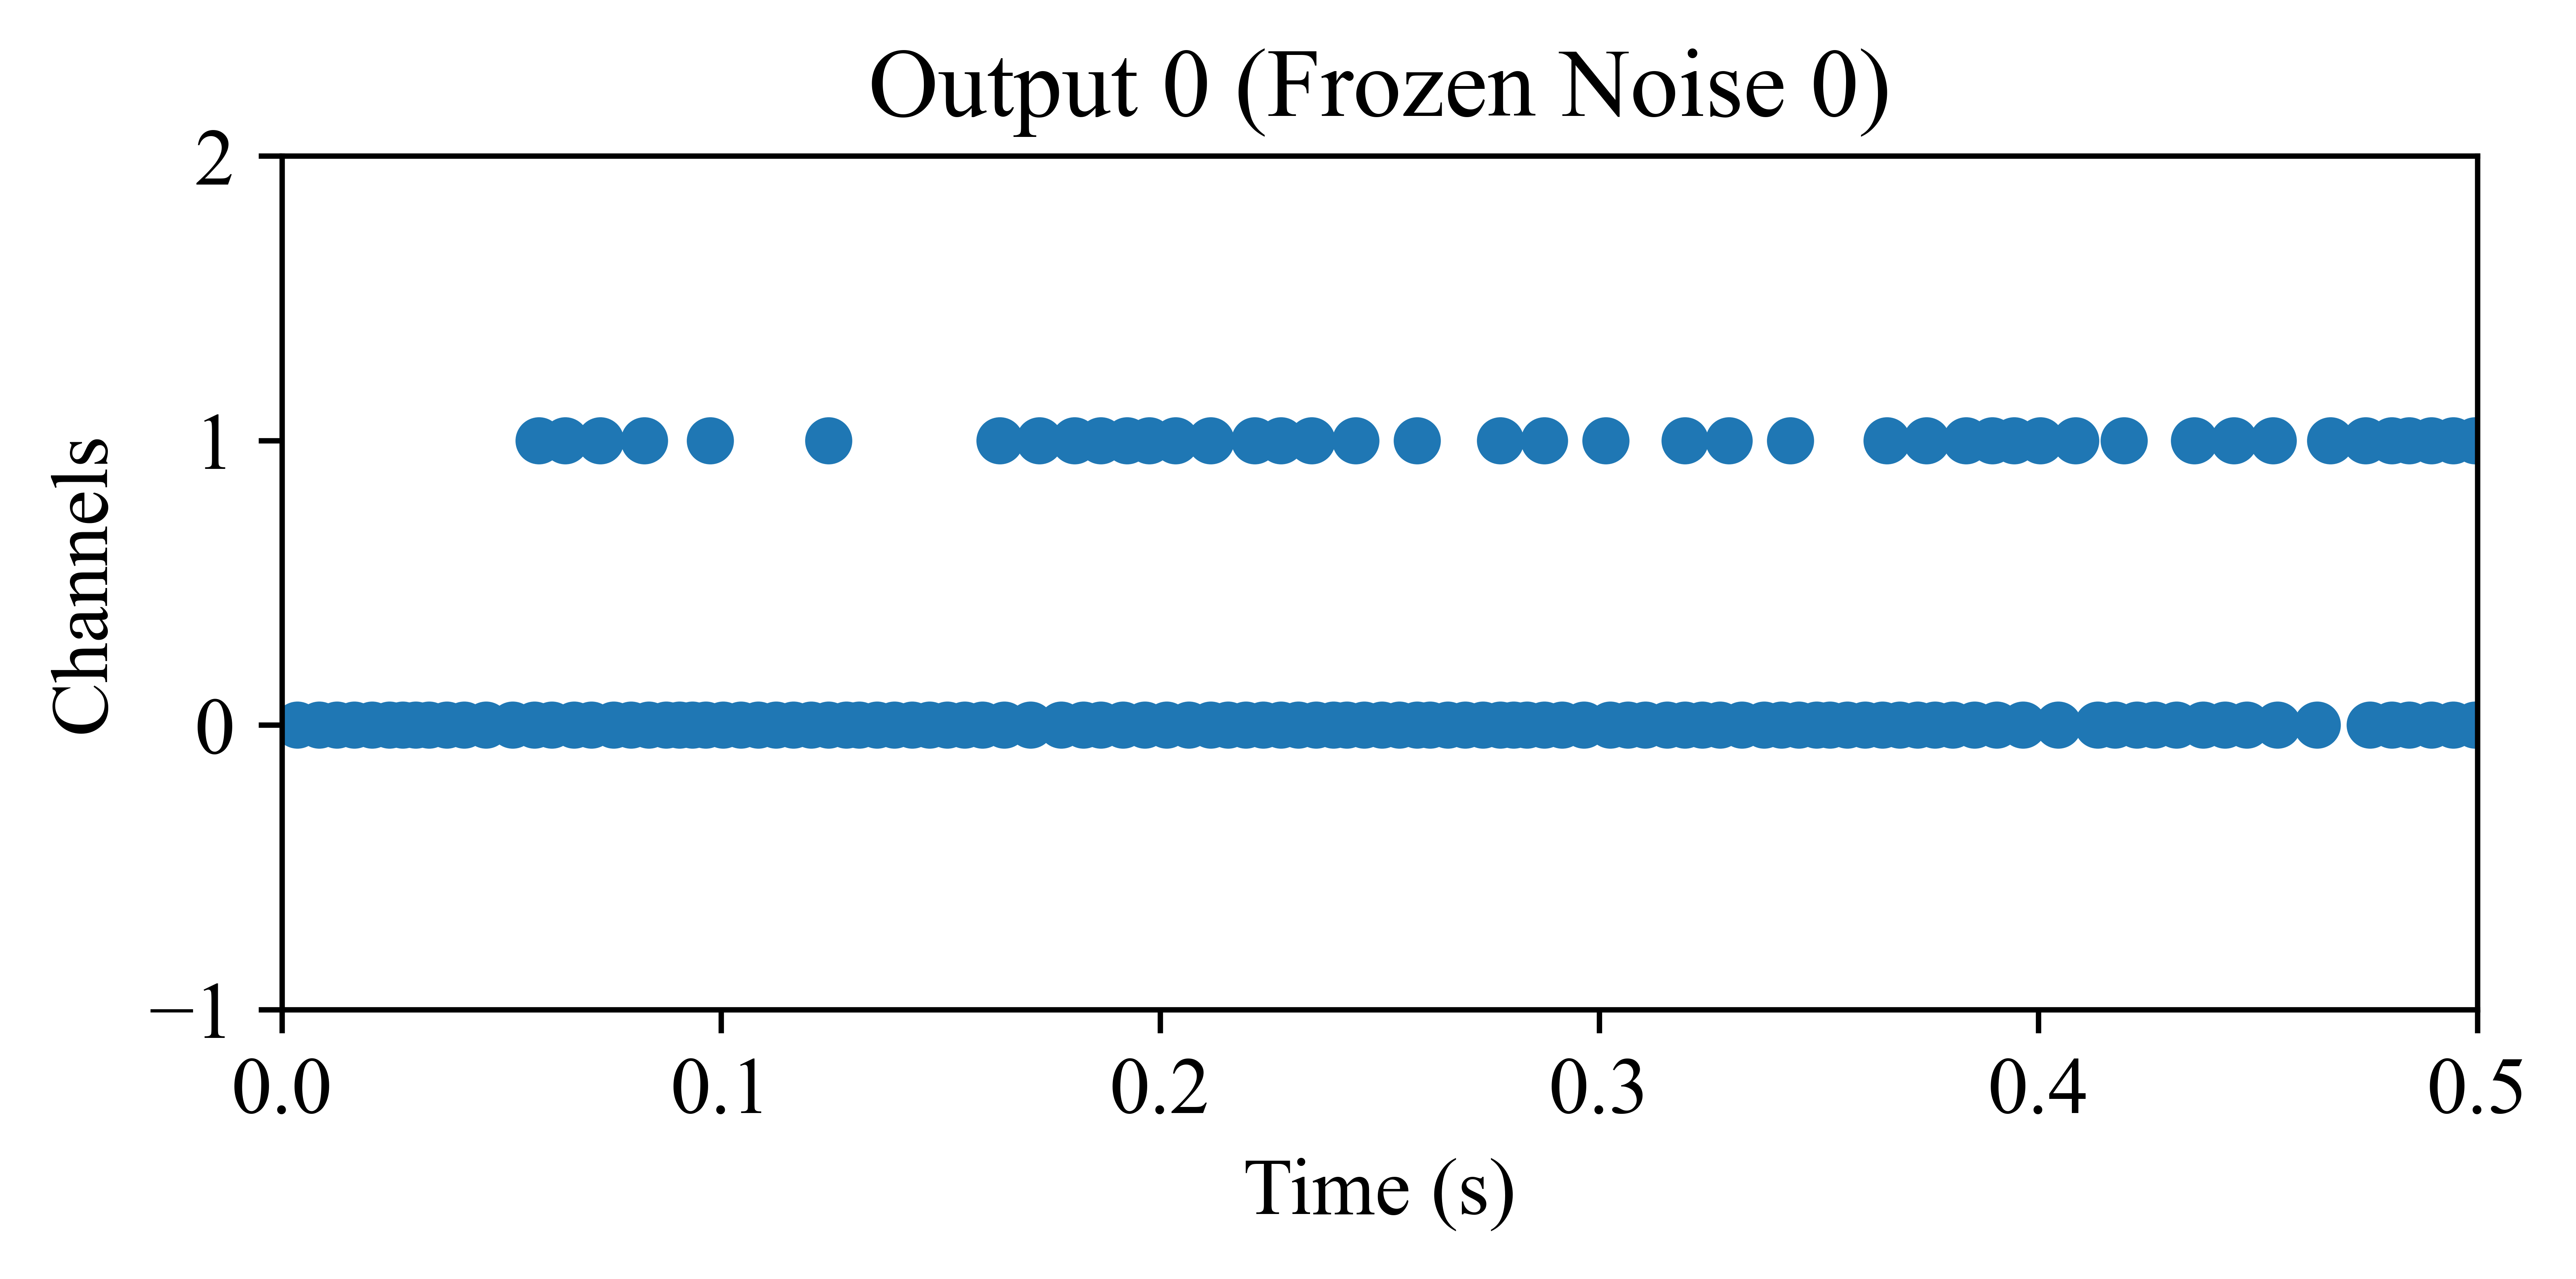

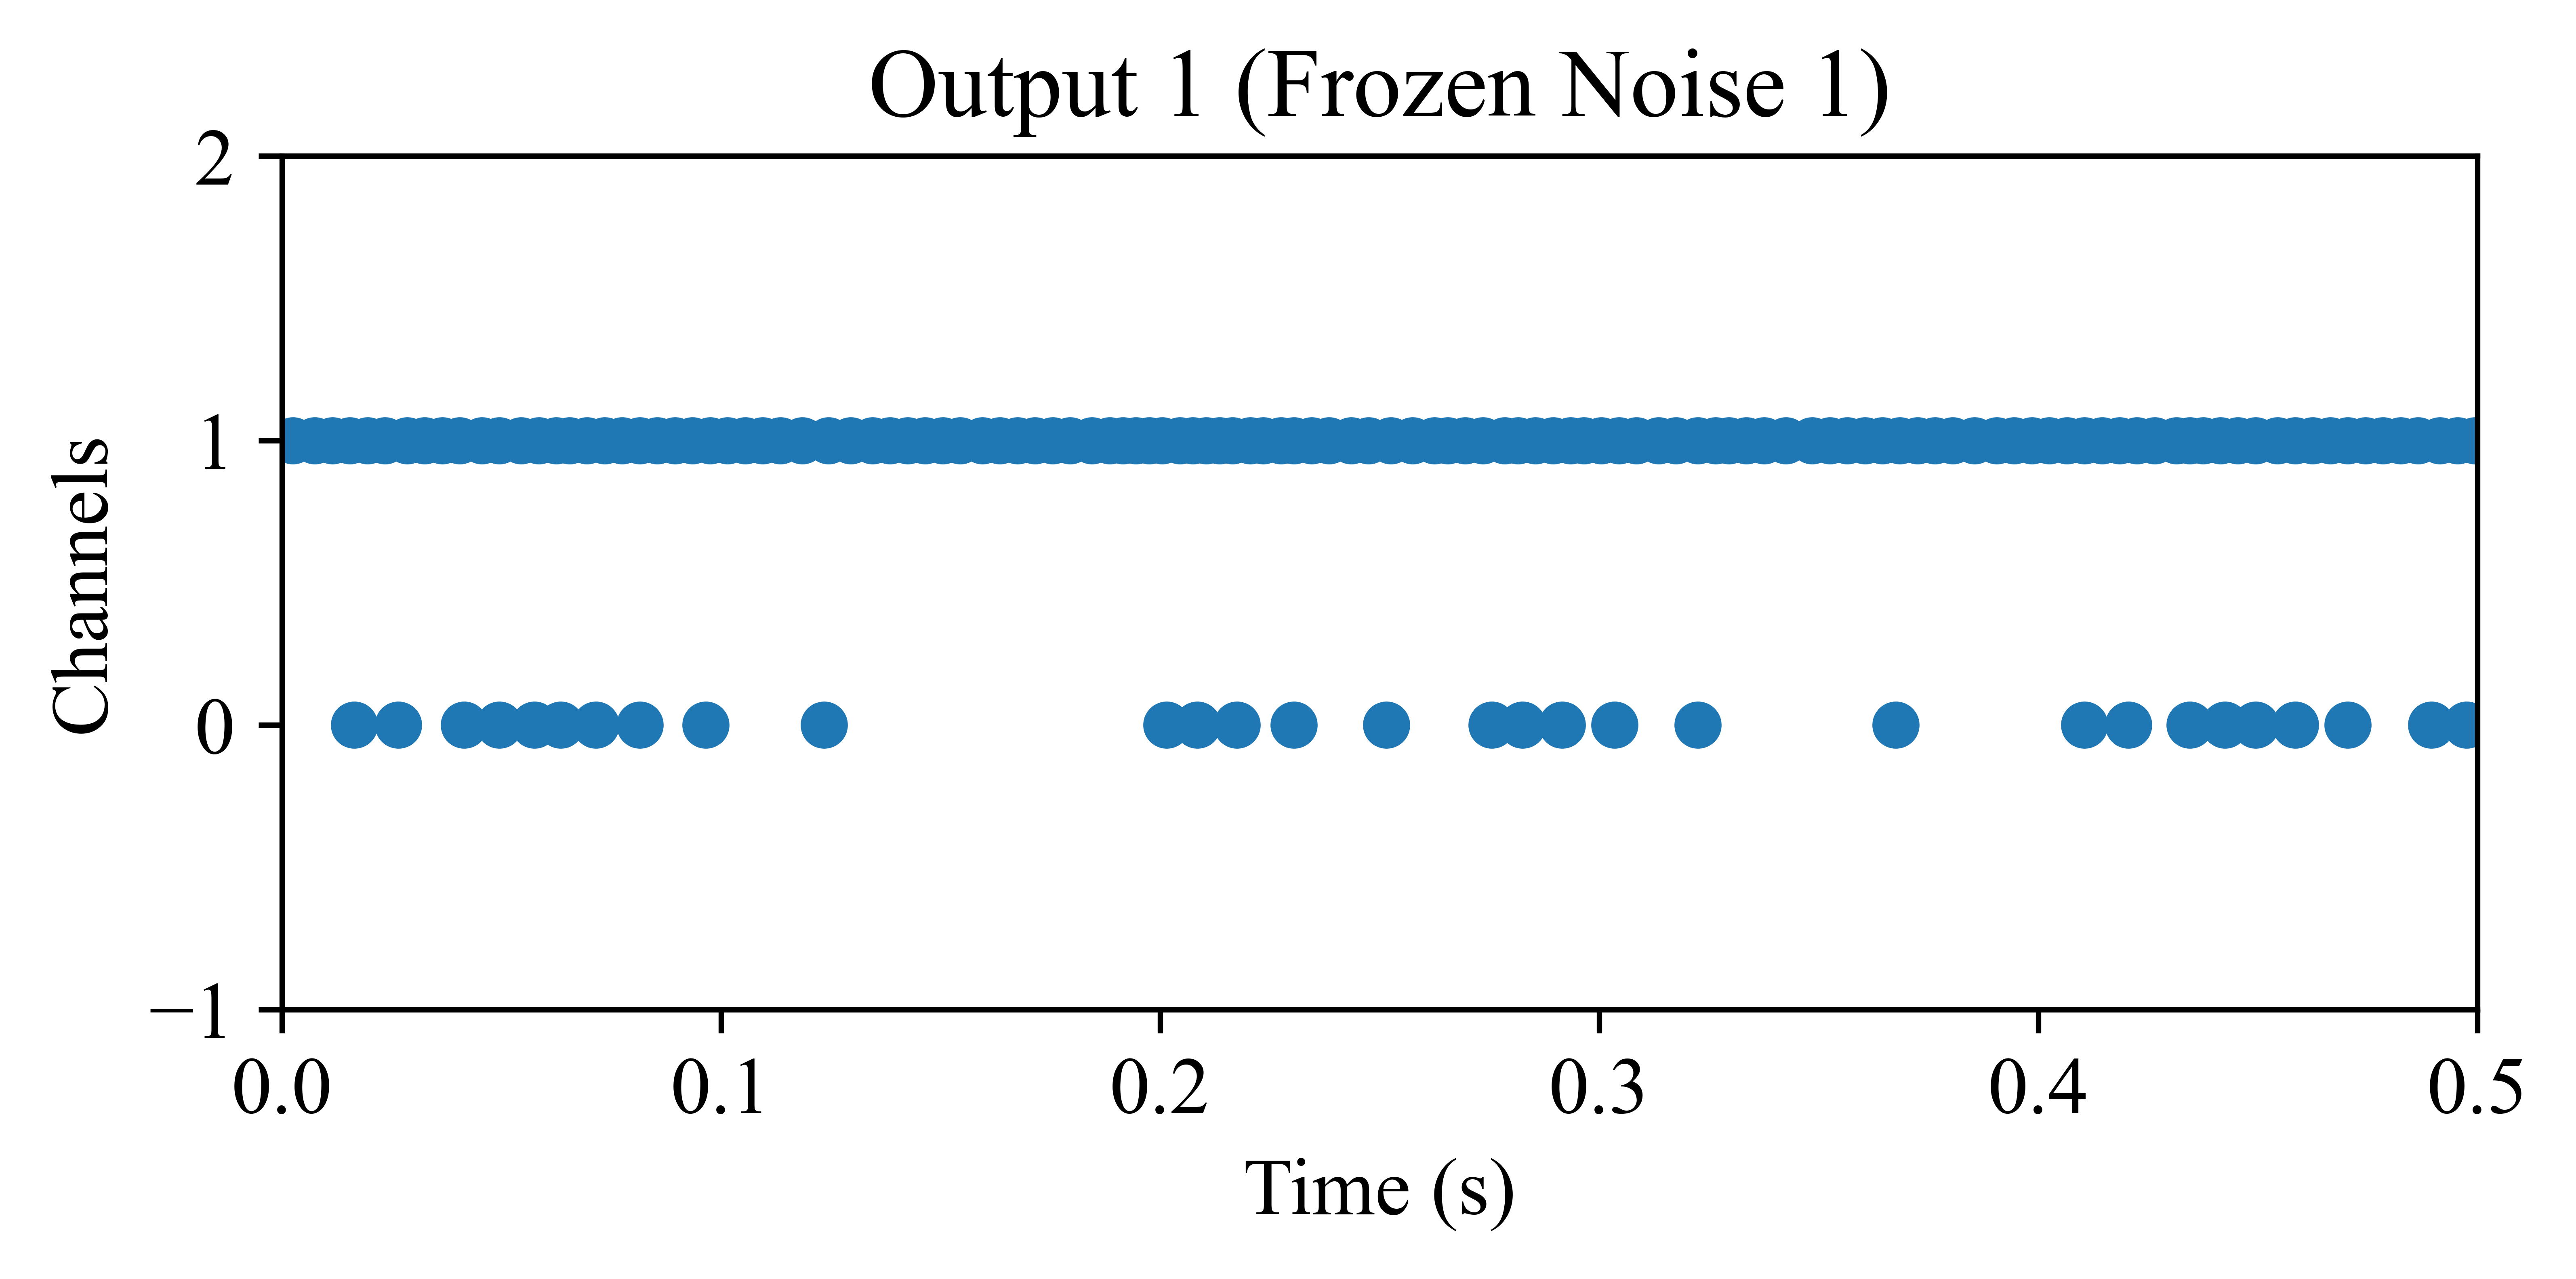

In [16]:
rec_init = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model_quantized.reset_state()
    out, _, rec = model_quantized(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

In [17]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna(se2_devices[0], config, input_channel_map)

In [18]:
se2.current_timestamp()

9.682127999999999

In [19]:
def test_network(se2, spec, instance):

    sample, label = instance
    out, state, rec = se2(sample, record=True)

    fig, axes = plt.subplots(2, 1)
    ticks = list(rec["channel_map"].keys())
    labels = [dest.tag for dest in rec["channel_map"].values()]

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot()
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=rec["start_time"], t_stop=rec["stop_time"]+se2.dt, dt=se2.dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

Rate = 36.0


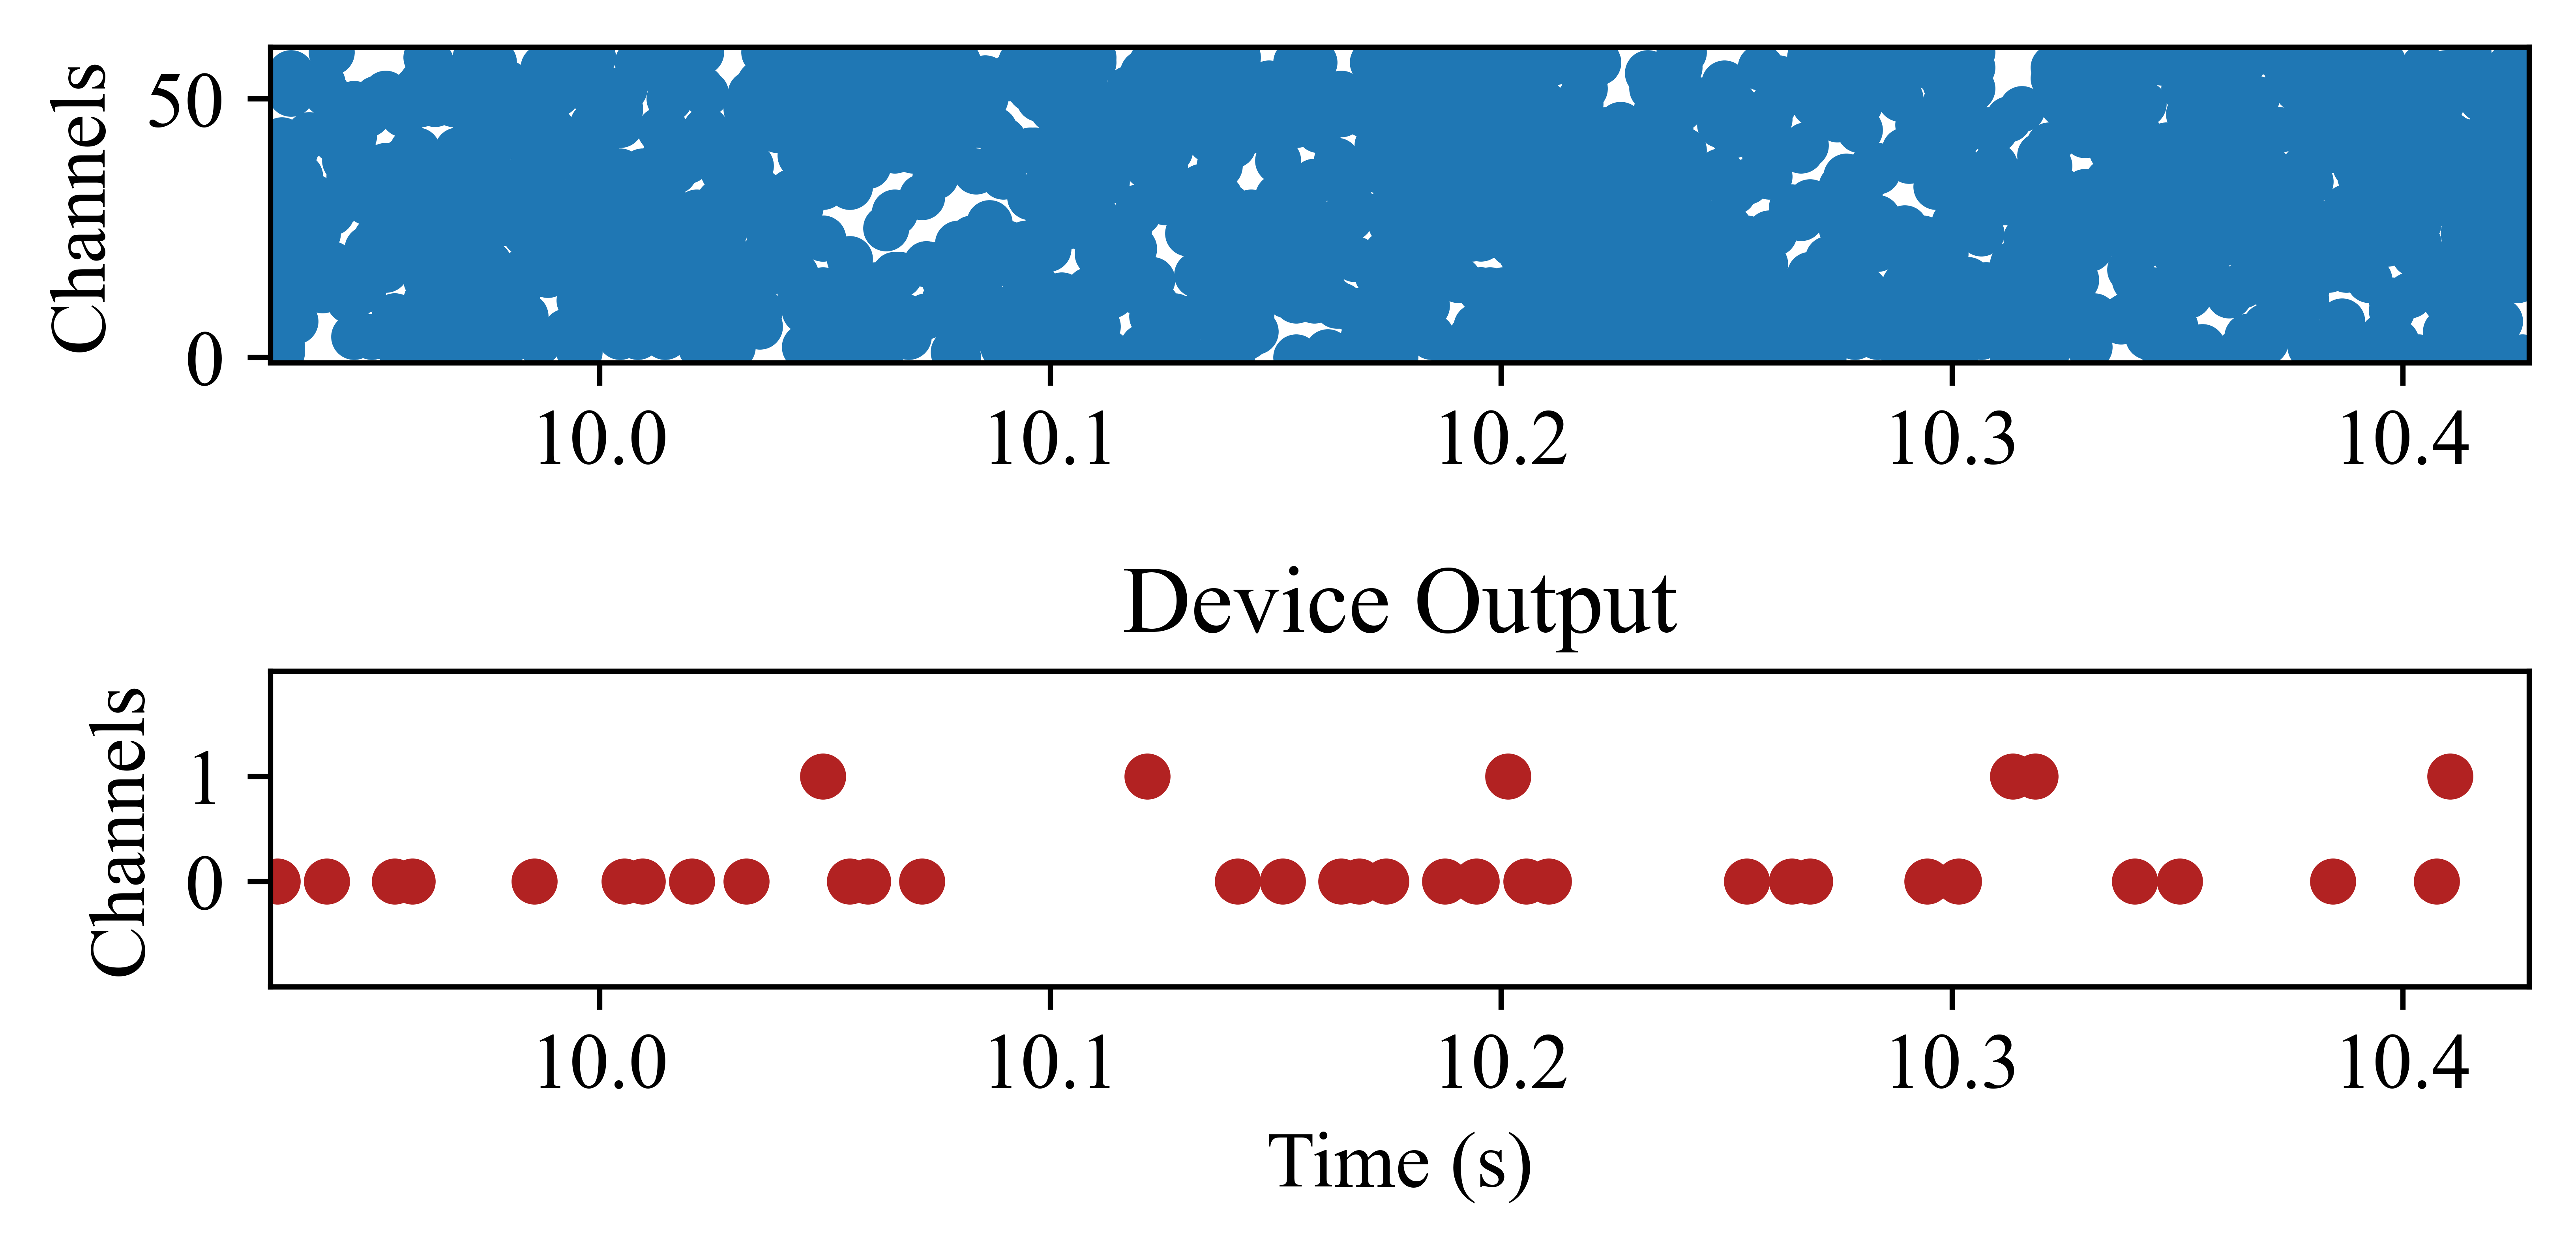

In [20]:
test_network(se2, spec, train_data[0])

Rate = 44.0


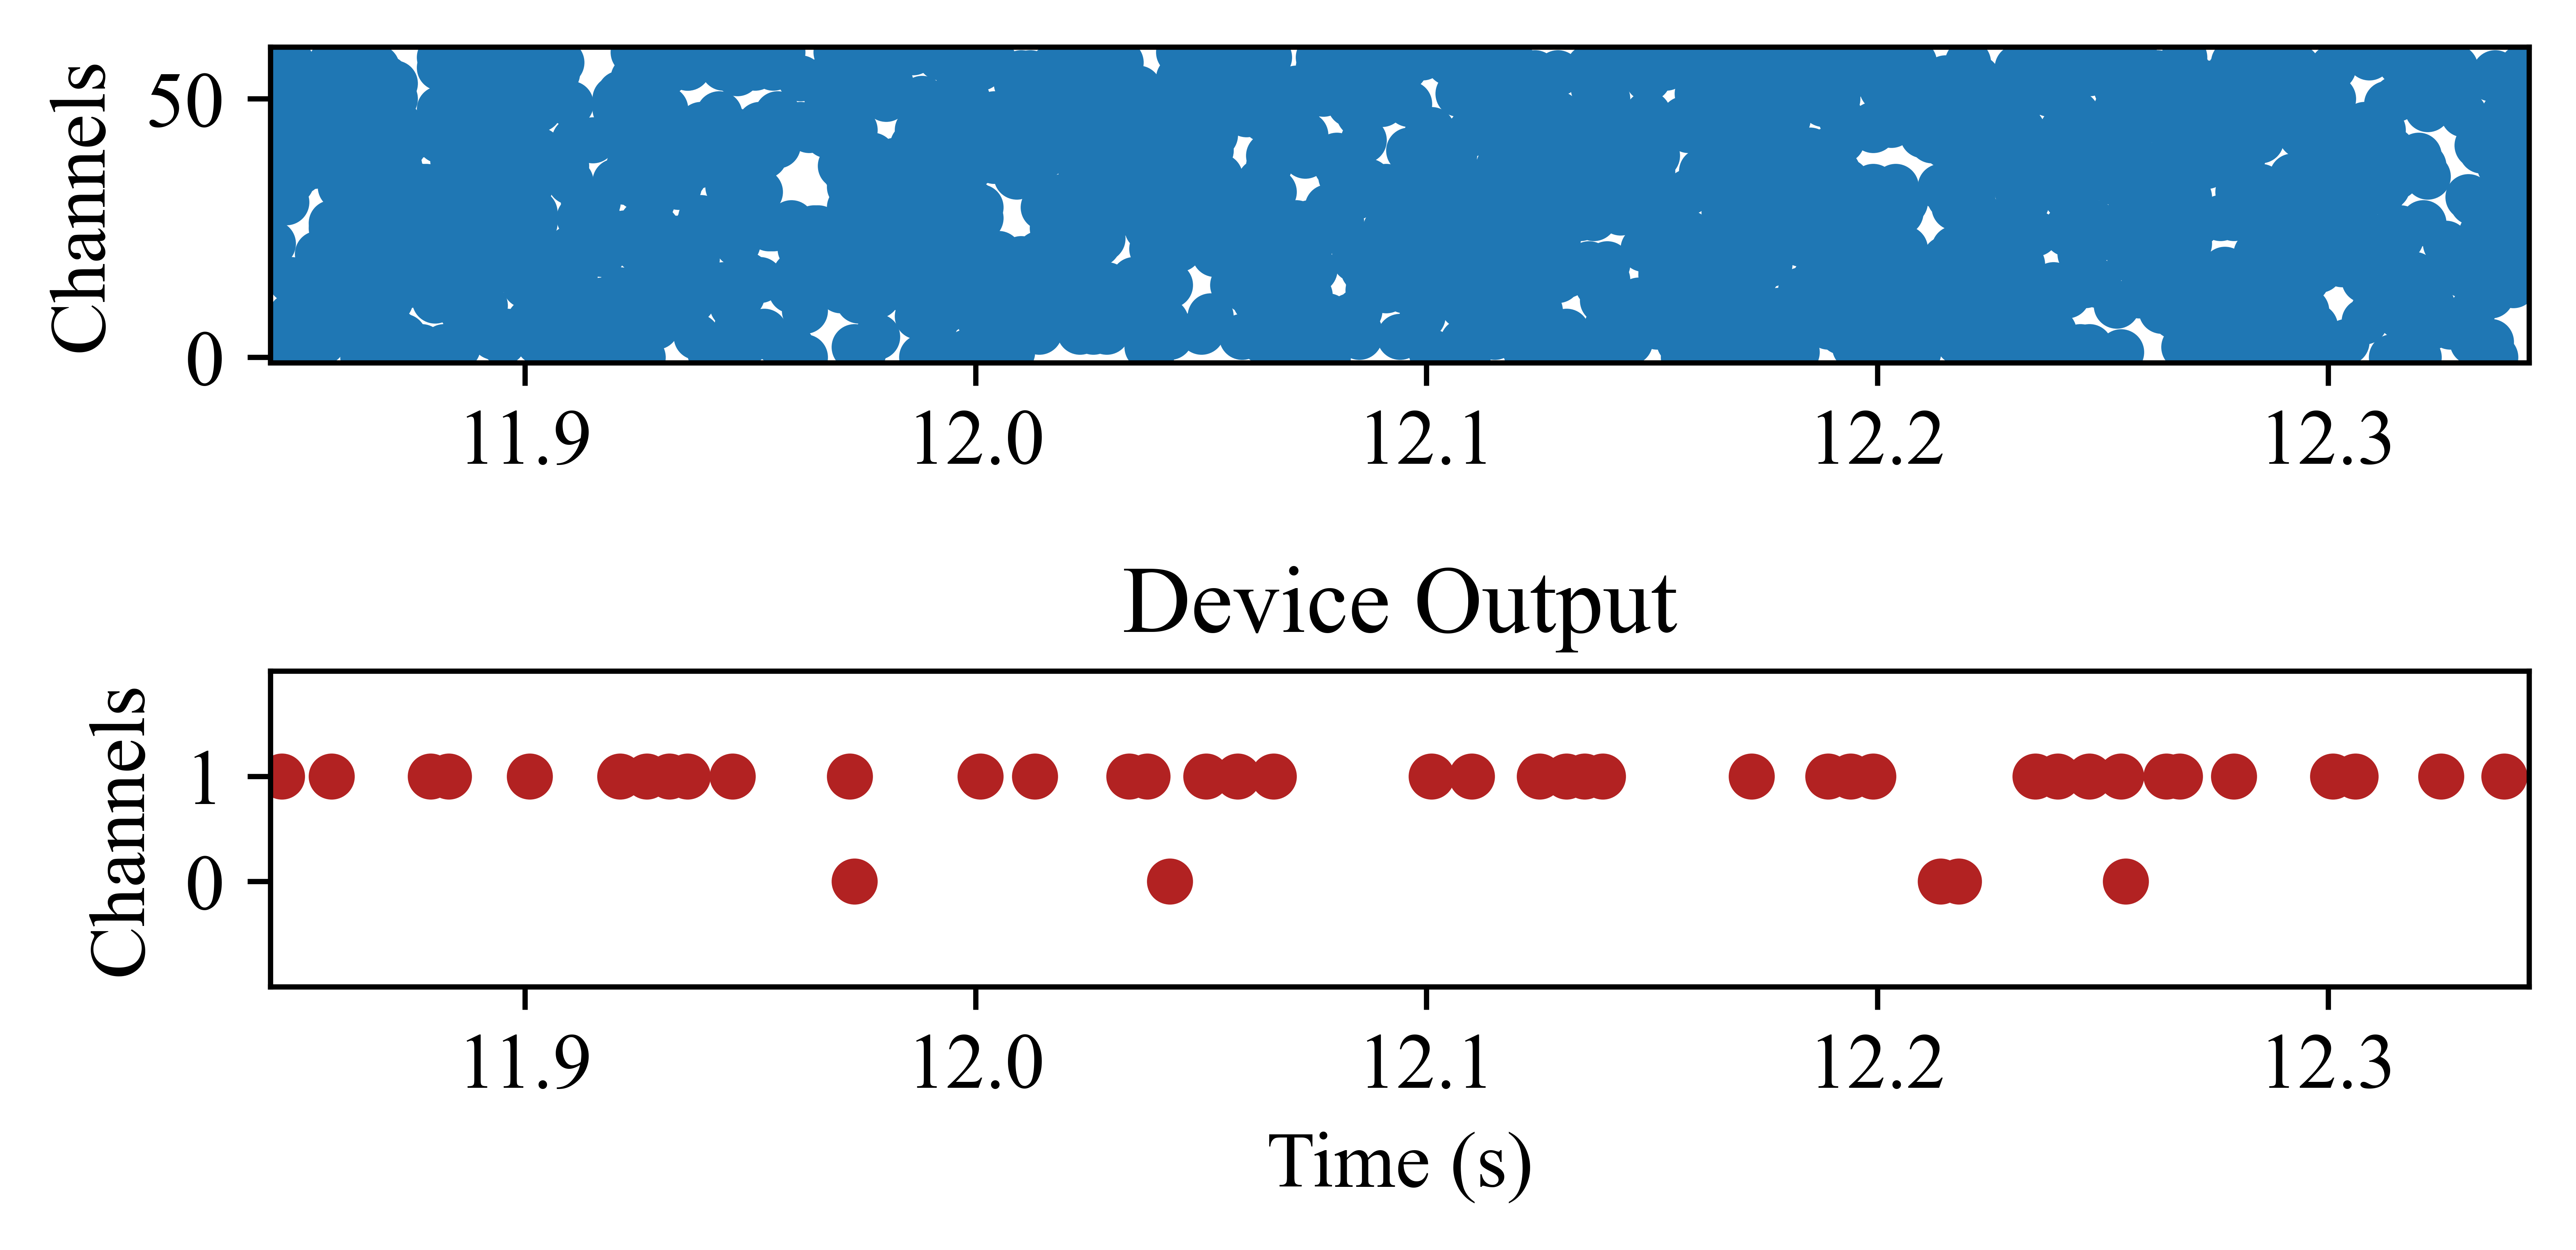

In [21]:
test_network(se2, spec, train_data[1])

Rate = 41.0


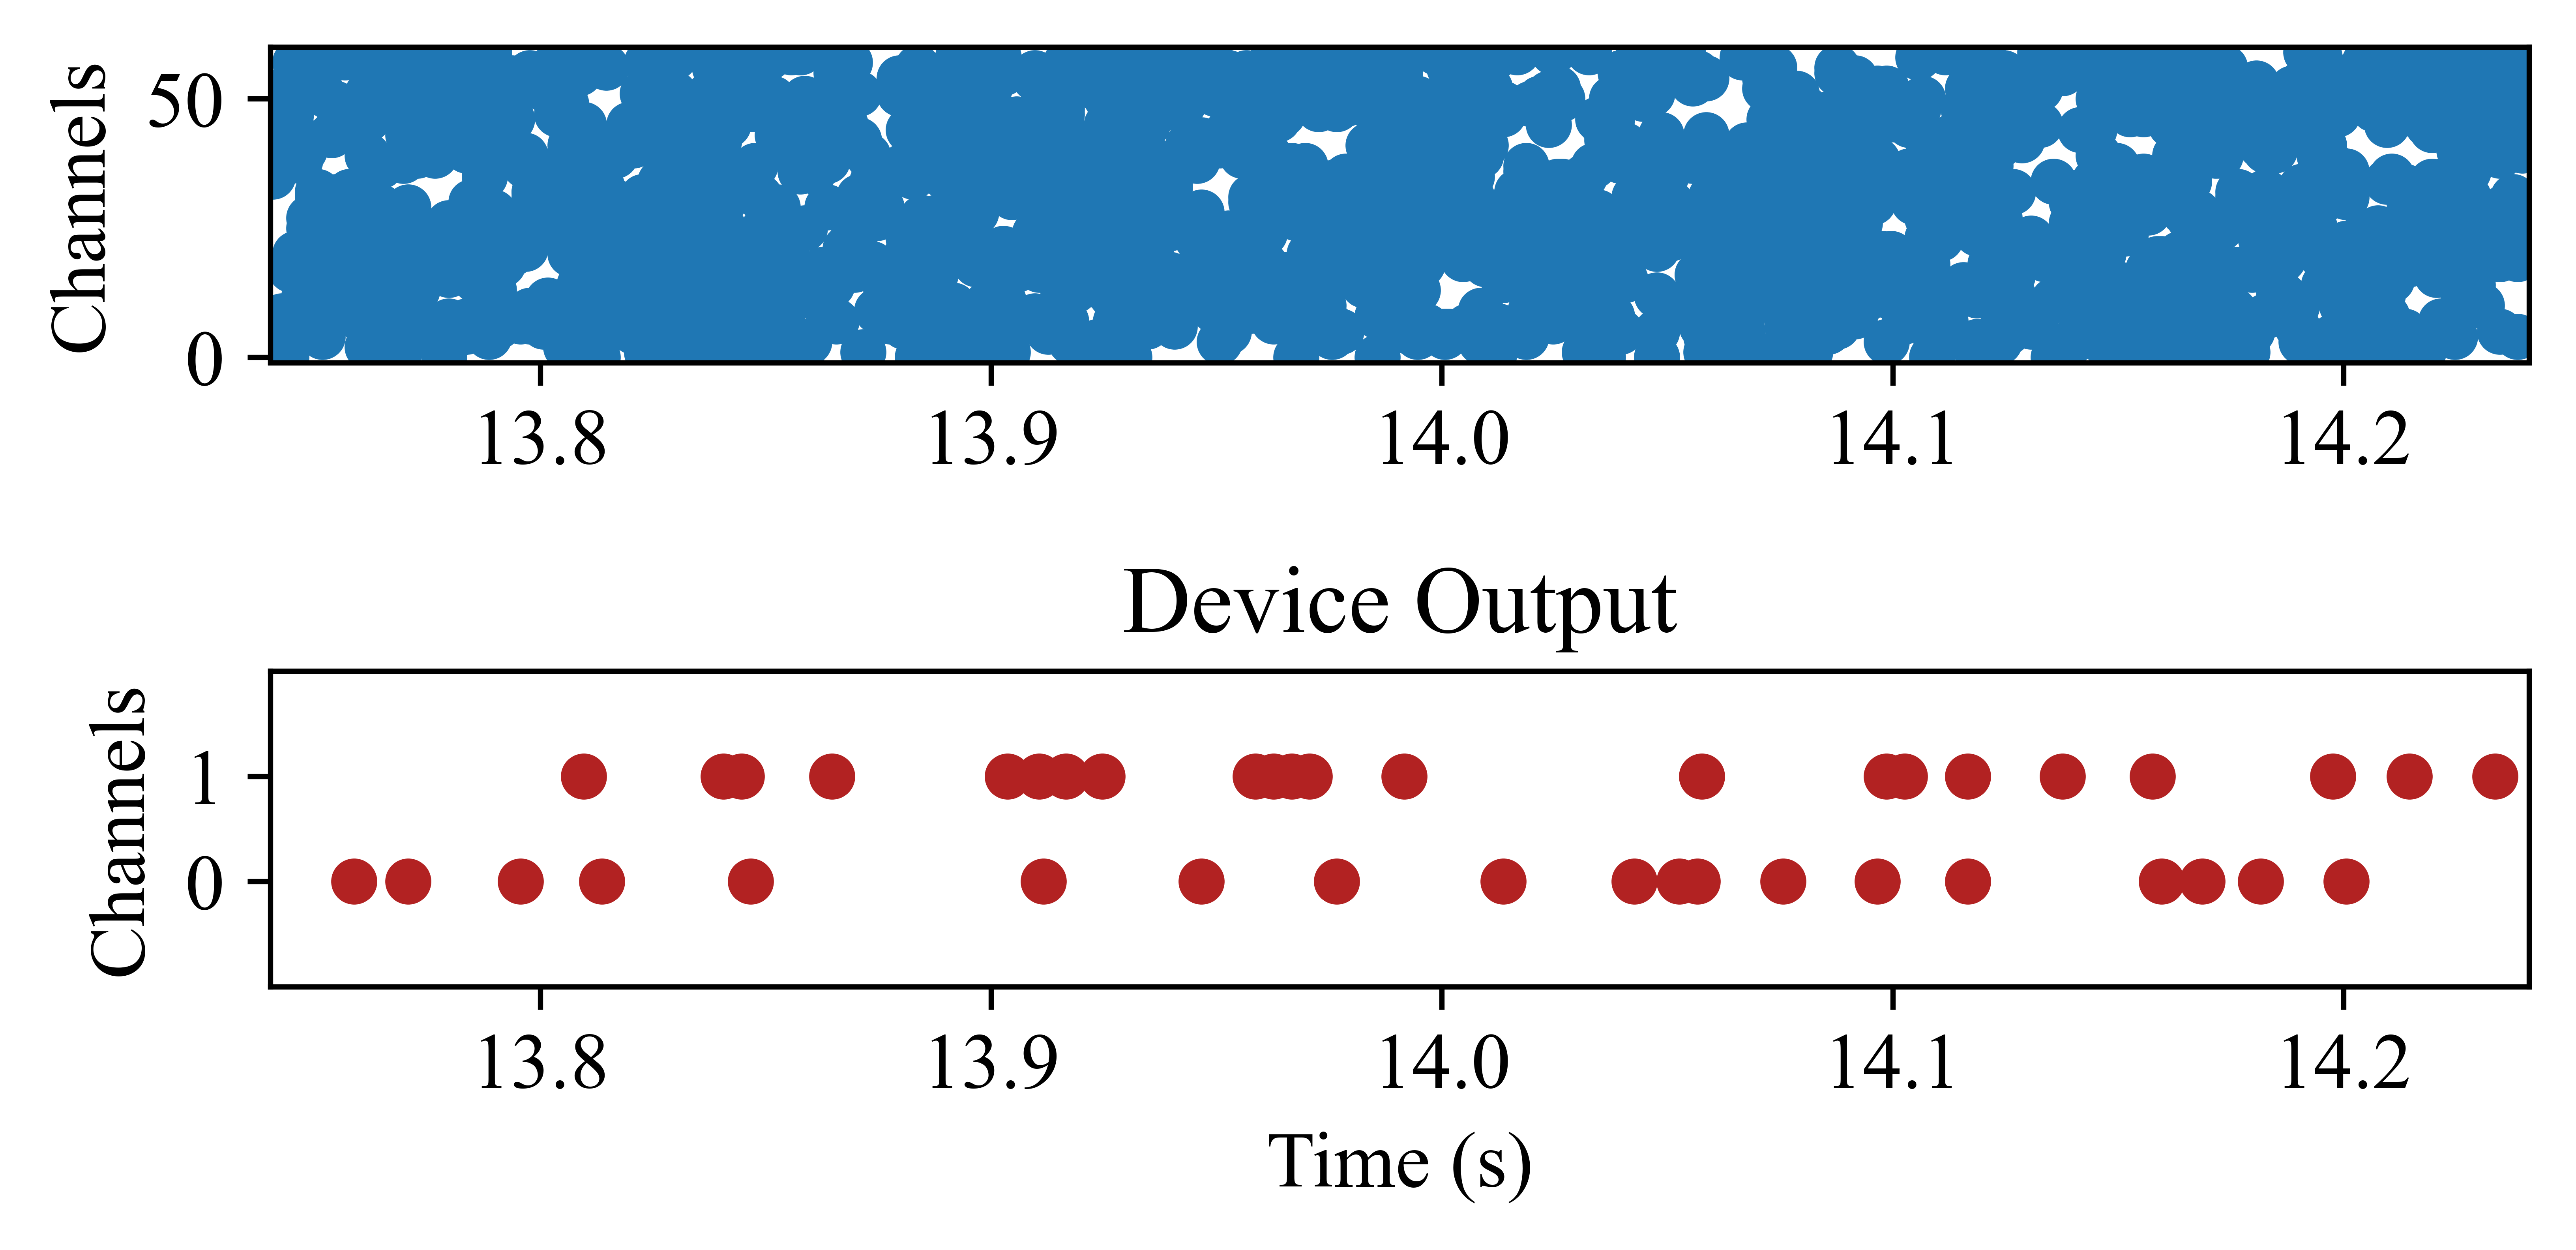

In [22]:
test_network(se2, spec, test_data[0])

Rate = 46.0


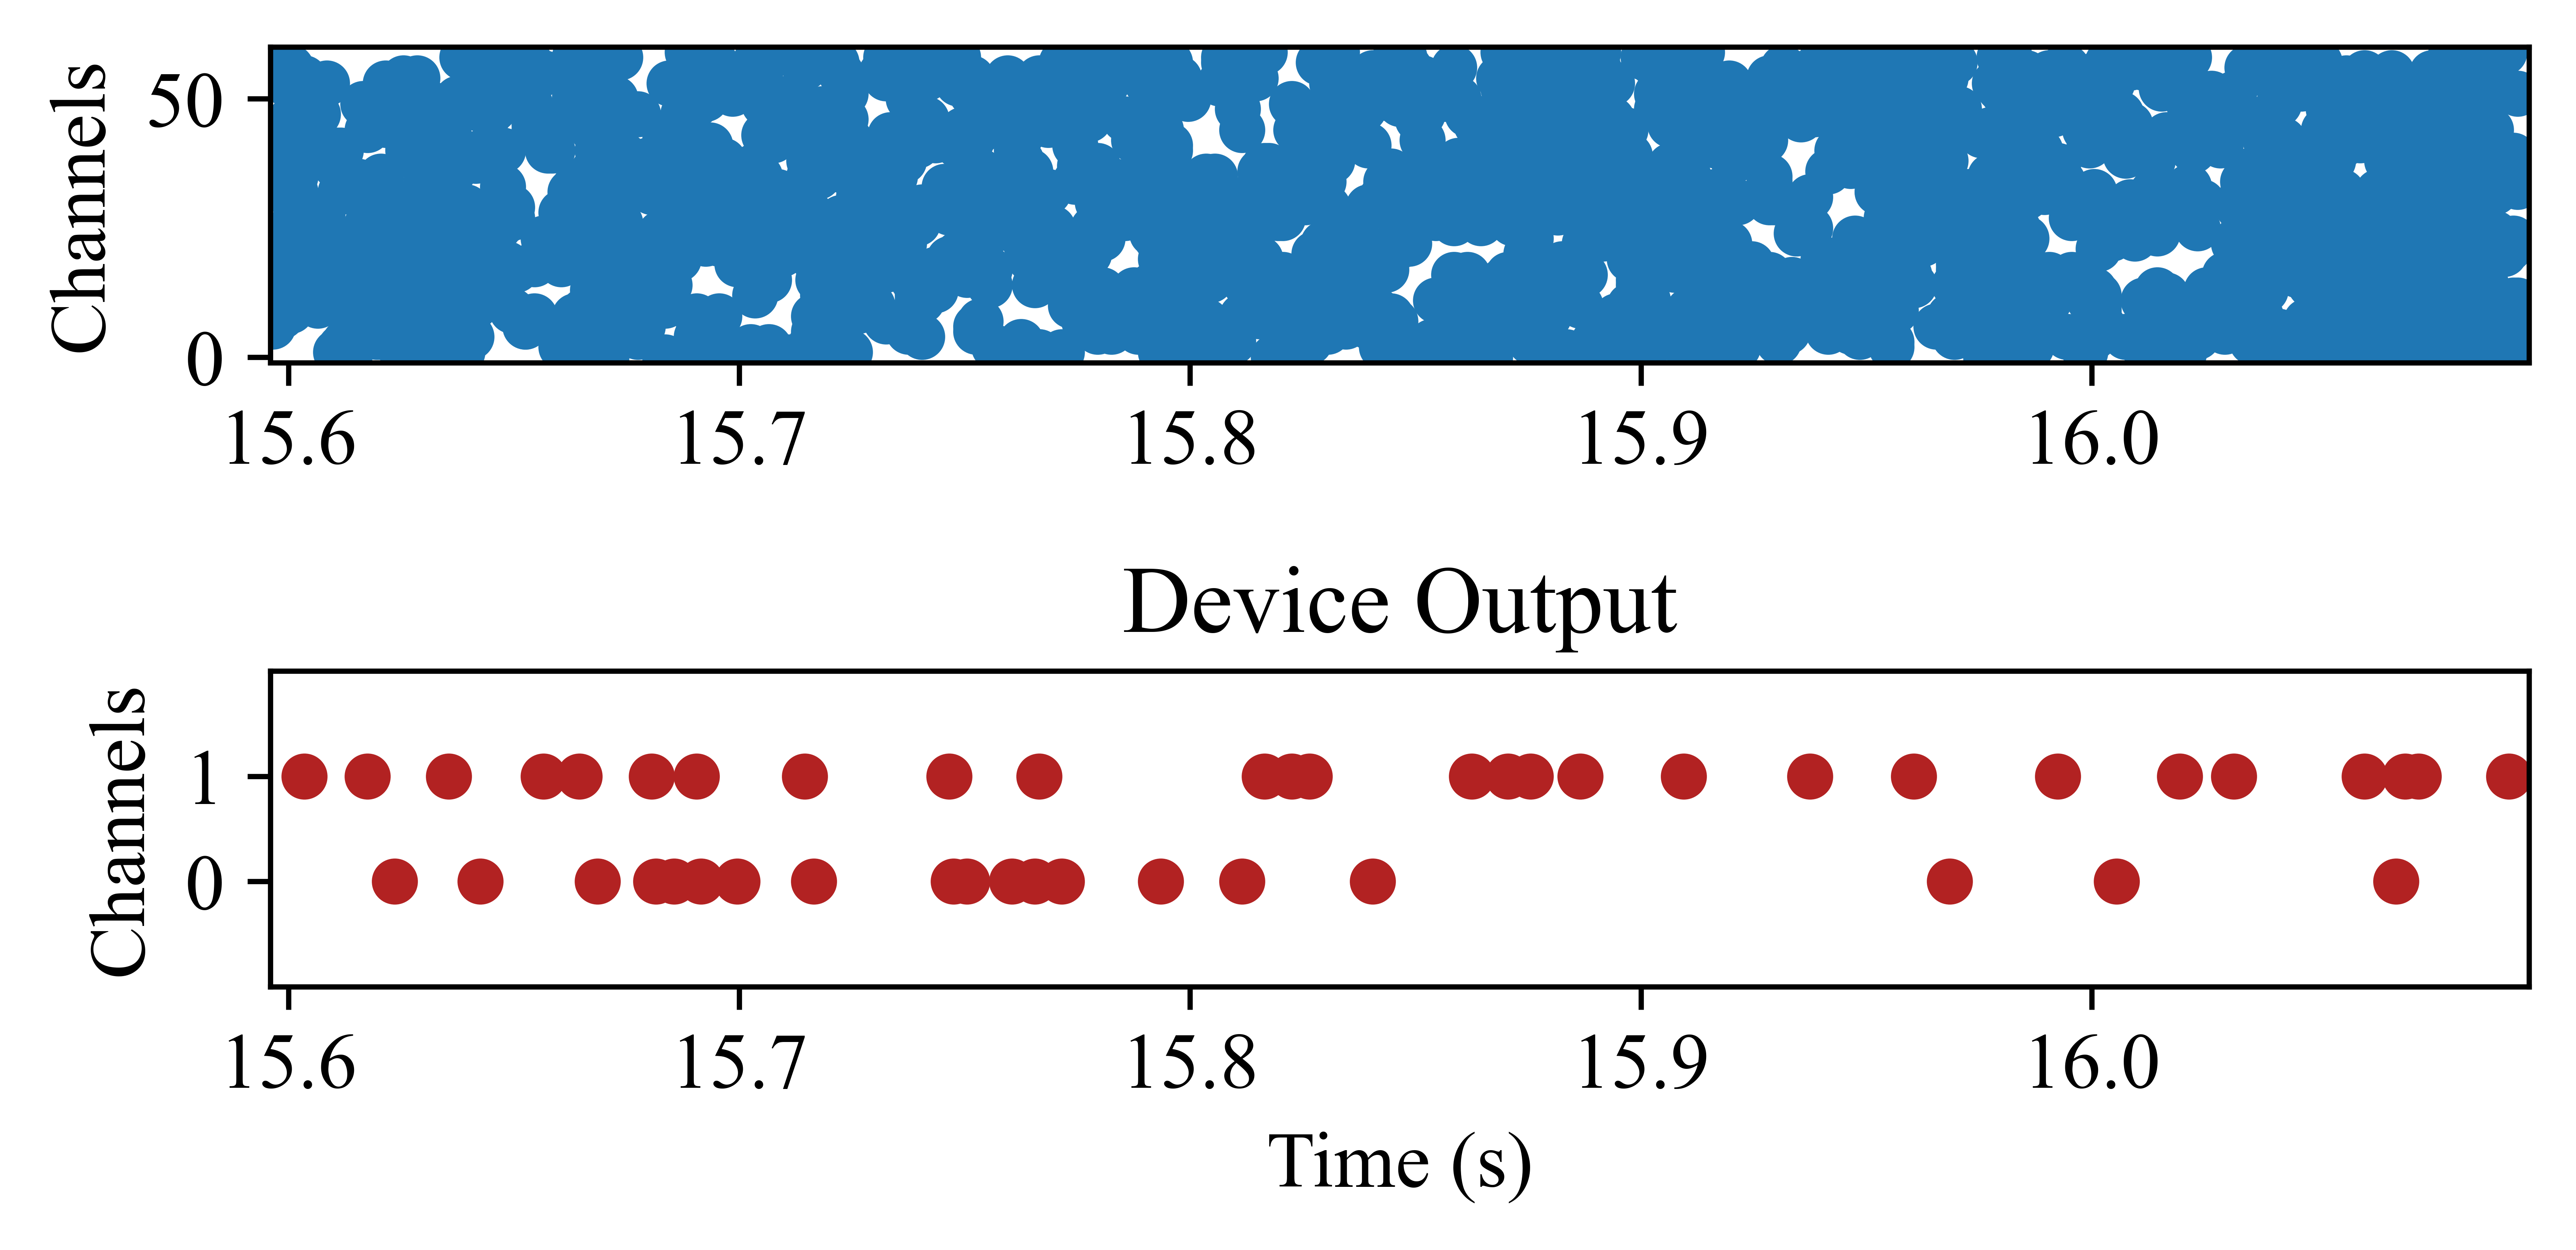

In [23]:
test_network(se2, spec, test_data[1])

Rate = 45.0


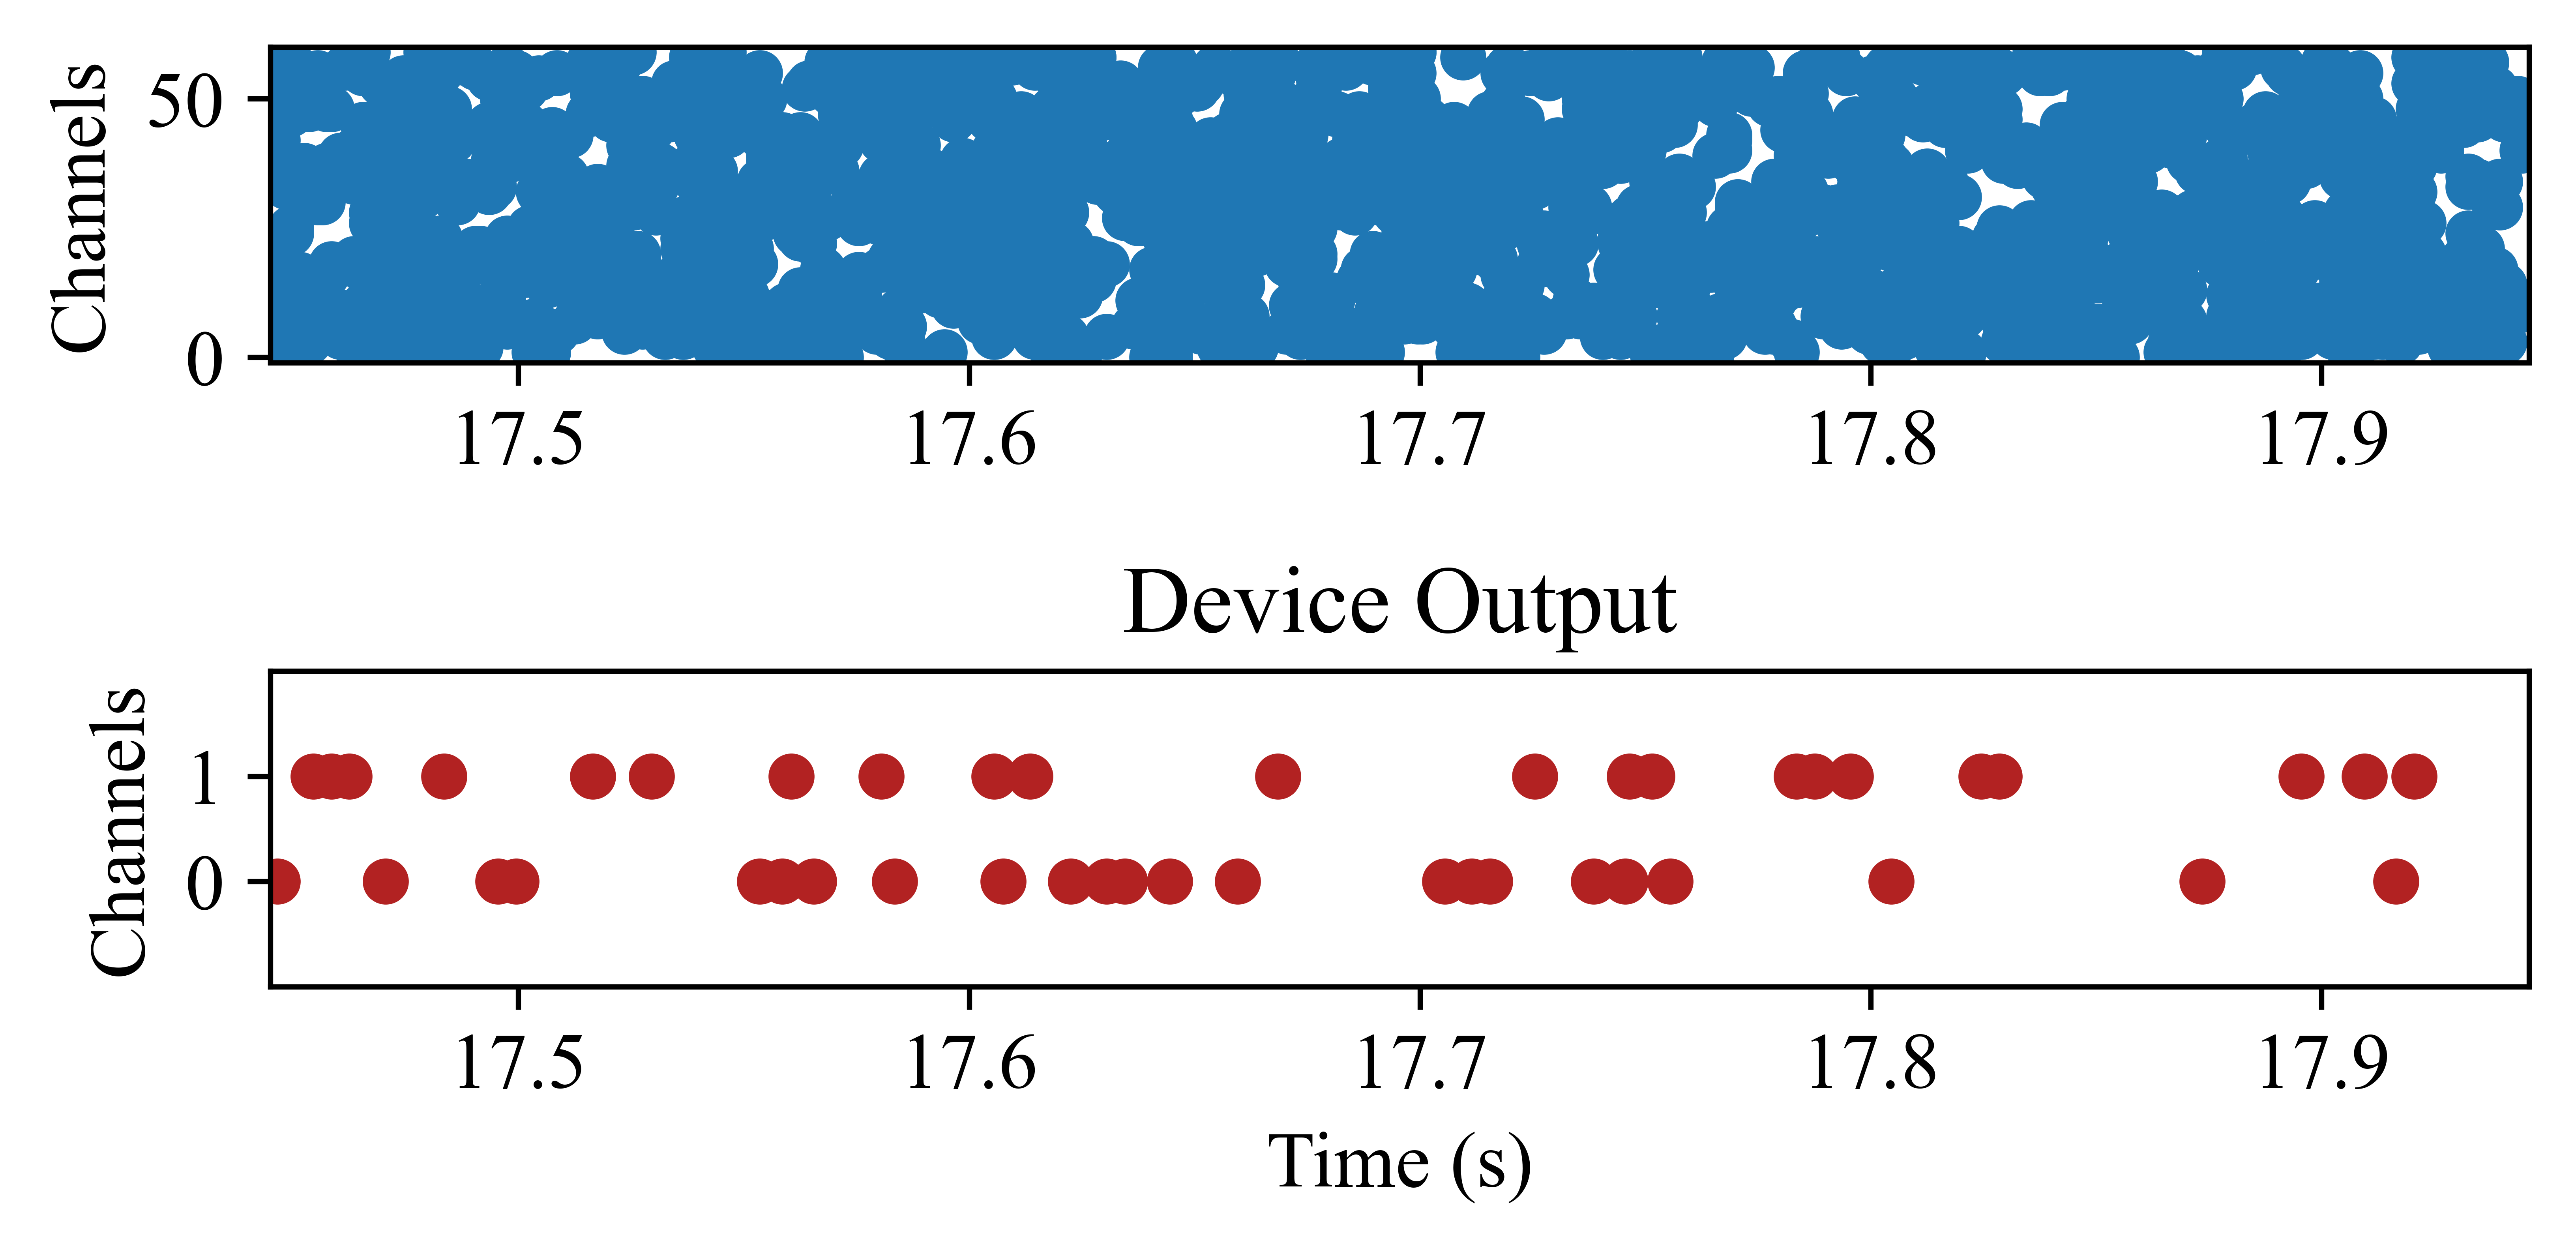

In [24]:
test_network(se2, spec, test_data[2])